#Майнор ИАД. Домашнее задание 3. YOLO.

В этом задании вы напишете и обучите свой собственный YOLO детектор. Нужно будет разобраться со статьей: понять какого формата должна быть обучающая пара (x, y), как перевести лосс из математической формулы в питоновский код - ну и конечно понять и реализовать саму архитектуру модели.

Выборка на котрой мы будем обучать модель состоит из разнообразных фотографий яблок, бананов и апельсинов. Данные скачиваем [отсюда](https://drive.google.com/file/d/1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3/view?usp=sharing).

Баллы за ДЗ распределены следующим образом: 
- Выборка для YoloV1 - 2 балла
- YOLO модель - 2 балла
- YOLO Loss - 3 балла
- Вспомогательные функции - 2 балла
- Обучение и расчет метрик - 2 балла

Для построения и обучения можно использовать как pytorch, так и pytorch-lightning.

Да-да, баллов в сумме получается 11

In [1]:
# Данная библиотека понадобится нам, чтобы обработать разметку
! pip install xmltodict pytorch-lightning -q
! pip install wandb -q

     |████████████████████████████████| 800 kB 14.7 MB/s 
     |████████████████████████████████| 125 kB 79.6 MB/s 
     |████████████████████████████████| 512 kB 74.7 MB/s 
     |████████████████████████████████| 1.9 MB 14.9 MB/s 
     |████████████████████████████████| 182 kB 60.2 MB/s 
     |████████████████████████████████| 174 kB 57.6 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 173 kB 55.1 MB/s 
     |████████████████████████████████| 168 kB 72.1 MB/s 
     |████████████████████████████████| 168 kB 59.4 MB/s 
     |████████████████████████████████| 166 kB 55.5 MB/s 
     |████████████████████████████████| 166 kB 71.5 MB/s 
     |████████████████████████████████| 162 kB 64.8 MB/s 
     |████████████████████████████████| 162 kB 56.4 MB/s 
     |████████████████████████████████| 158 kB 60.1 MB/s 
     |████████████████████████████████| 157 kB 22.0 MB/s 
     |████████████████████████████████| 157 kB 66.2 MB/s 
     |██████████

Скачаем данные

In [2]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q data.zip
!rm data.zip
!ls -l

total 12
drwx------ 4 root root 4096 Nov 26 08:32 data
drwxr-xr-x 3 root root 4096 Dec 19 10:59 __MACOSX
drwxr-xr-x 1 root root 4096 Dec 16 00:01 sample_data


Посмотрим как выглядит один из файлов разметки

In [3]:
!cat data/train/apple_3.xml

<annotation>
	<folder>train</folder>
	<filename>apple_3.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_3.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>1000</width>
		<height>708</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>1</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>584</xmin>
			<ymin>438</ymin>
			<xmax>867</xmax>
			<ymax>708</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>492</xmin>
			<ymin>141</ymin>
			<xmax>740</xmax>
			<ymax>394</ymax>
		</bndbox>
	</object>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>176</xmin>
			<ymin>199</ymin>
			<xmax>490</xmax>
			<ymax>466</ymax>
		</bndbox>
	</object>
	<obj

## Релизуйте выборку для YoloV1 - 2 балла

In [1]:
import os
import cv2
import json
import glob
import tqdm
import xmltodict
from IPython.core.display import struct
from typing import List
import pandas as pd
import numpy as np
import torch
import torchvision
from torch import nn
# from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
import albumentations as A
import albumentations.pytorch
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from PIL import Image
from albumentations.pytorch import ToTensorV2
import copy
from PIL import ImageDraw
import secrets
import time

# additional imports
from tqdm.notebook import tqdm as tqdm
import wandb
import gc
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Connected device is {device}')

Connected device is cuda


In [2]:
!wandb login

wandb: Currently logged in as: nikitaermishov. Use `wandb login --relogin` to force relogin


Так как в этом домашнем задании использовать аугментации для обучения __обязательно__ - советуем воспользоваться библиотекой albumentations.

Она  особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Для знакомства с этим механизмом советуем следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). 

Вы все еще можете избрать путь torchvision.transforms, вам потребуется знакомый нам метод `__getitem__`, однако вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную

__Обратите внимание__ на то, что в статье коробки предсказаний параметризуются через: _(x_center, y_center, width, height)_ (причем эти значения _относительные_), а в наших файлах - это _(x_min, y_min, x_max, y_max)_

Также, помните что модель должна предсказывать как прямоугольник с обьектом, так и вероятности каждого класса!

In [3]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}
S, B, C = 7, 2, 3

def get_class_and_color(search_tag):
    color = ''
    for class_, tag in class2tag.items():
        if tag == search_tag:
            if tag == 1:
                color = 'g'
            elif tag == 2:
                color = 'orange'
            else:
                color = 'y'
            return (class_, color)

class FruitDataset(Dataset):
    def __init__(self, data_dir, S=7, B=2, C=3, transforms=None):
        self.image_paths = [os.path.join(data_dir, image_path) for image_path in os.listdir(data_dir) if image_path.endswith('.jpg')]
        self.box_paths = [os.path.join(data_dir, box_path) for box_path in os.listdir(data_dir) if box_path.endswith('.xml')]
        self.data_dir = data_dir
        self.S = S
        self.B = B
        self.C = C

        assert len(self.image_paths) == len(self.box_paths)

        self.transforms = transforms

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx]).astype(np.float32)/255.0
        # print(self.image_paths[idx])
        bboxes, class_labels = self.__get_boxes_from_xml(self.image_paths[idx].replace('.jpg', '.xml'))

        if self.transforms:
            image, bboxes, class_labels = self.transforms(image=image, bboxes=bboxes, class_labels=class_labels).values()
        
        confidence = 1.0
        image_size = image.shape[0]
        target = torch.zeros((self.S, self.S, self.C + 5 * self.B), dtype=torch.float)
        cell_ratio = 1./self.S
        for idx, bbox in enumerate(bboxes):
            x_center, y_center, width, height = bbox
            label = class_labels[idx]
            row_location = int(np.floor(x_center/cell_ratio))
            column_location = int(np.floor(y_center/cell_ratio))

            x_center_relative = ((x_center/cell_ratio) - row_location)
            y_center_relative = ((y_center/cell_ratio) - column_location)
            width_relative = width *self.S
            height_relative = height *self.S

            if target[row_location, column_location, self.C+4] == 0:
                box_coordinates = torch.tensor(
                  [x_center_relative, y_center_relative, width_relative, height_relative]
                )
                target[row_location, column_location, self.C:self.C+4] = box_coordinates
                target[row_location, column_location, label-1] = 1 
                target[row_location, column_location, self.C+4] = confidence
        
        return image, target

    def __len__(self):
        return len(self.image_paths)

    def __get_boxes_from_xml(self, xml_filename: str):
        """
        Метод, который считает и распарсит (с помощью xmltodict) переданный xml
        файл и вернет координаты прямоугольников обьектов на соответсвующей фотографии
        и название класса обьекта в каждом прямоугольнике

        Обратите внимание, что обьектов может быть как несколько, так и один единственный
        """
        boxes = []
        class_labels = []

        xml_dict = {}

        with open(xml_filename, 'r') as xml_file:
            xml_content = xml_file.read()
            temp_dict = xmltodict.parse(xml_content)
            xml_dict = dict(temp_dict['annotation'])
        objects = xml_dict['object']
        self.coordinates = []
        if all(isinstance(n, dict) for n in objects):
            for obj in objects:
                coordinates_dict = obj.get('bndbox')
                x_min = int(coordinates_dict['xmin'])
                x_max = int(coordinates_dict['xmax'])
                y_min = int(coordinates_dict['ymin'])
                y_max = int(coordinates_dict['ymax'])
                self.coordinates.append([x_min, y_min, x_max, y_max])
                class_labels.append(class2tag.get(obj['name']))
        else:
            coordinates_dict = objects.get('bndbox')
            x_min = int(coordinates_dict['xmin'])
            x_max = int(coordinates_dict['xmax'])
            y_min = int(coordinates_dict['ymin'])
            y_max = int(coordinates_dict['ymax'])
            self.coordinates.append([x_min, y_min, x_max, y_max])
            class_labels.append(class2tag.get(objects['name']))
        if 'train' in  xml_dict['path']:
            path = os.path.join(self.data_dir, xml_dict['path'][61:])
        else:
            path = os.path.join(self.data_dir, xml_dict['path'][60:])
        img = Image.open(path)
        image_width, image_height = img.size
        for coordinate in self.coordinates:
            boxes.append(self.__convert_to_yolo_box_params(coordinate, image_width, image_height))
        return boxes, class_labels

    def __convert_to_yolo_box_params(self, box_coordinates: List[int], im_w, im_h):
        """
        Перейти от [xmin, ymin, xmax, ymax] к [x_center, y_center, width, height].
        
        Обратите внимание, что параметры [x_center, y_center, width, height] - это
        относительные значение в отрезке [0, 1]

        :param: box_coordinates - координаты коробки в формате [xmin, ymin, xmax, ymax]
        :param: im_w - ширина исходного изображения
        :param: im_h - высота исходного изображения

        :return: координаты коробки в формате [x_center, y_center, width, height]
        """
        ans = []

        ans.append((box_coordinates[0] + box_coordinates[2]) / 2 / im_w)  # x_center
        ans.append((box_coordinates[1] + box_coordinates[3]) / 2 / im_h)  # y_center
      
        ans.append((box_coordinates[2] - box_coordinates[0]) / im_w)  # width
        ans.append((box_coordinates[3] - box_coordinates[1]) / im_h)  # height
        return ans

In [4]:
WIDTH, HEIGHT = 448, 448

train_transform = A.Compose([
        A.Resize(HEIGHT, WIDTH),
        A.ColorJitter(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2()
    ],  bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
test_transform = A.Compose([
        A.Resize(HEIGHT, WIDTH),
        ToTensorV2()
    ],
        bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

In [5]:
train_dataset = FruitDataset(
    transforms=train_transform,
    data_dir="./data/train"
    )

val_dataset = FruitDataset(
    transforms=test_transform, 
    data_dir="./data/test"
    )

# Немного проверок, чтобы убедиться в правильности направления решения
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[0][0], torch.Tensor)
print("Тесты успешно пройдены")

Тесты успешно пройдены


In [6]:
import matplotlib.patches as patches
def visualize_data(dataset, idx=0, samples=10, cols=5, random=True, S=7):
    dataset = copy.deepcopy(dataset)
    # dataset.transforms = A.Compose([t for t in dataset.transform.transforms if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=((16, 8)))
    for i in range(samples):
        if random:
            idx = np.random.randint(1,len(dataset))
        image, target_tensor = dataset[idx]
        image = image.detach().numpy()
        image = image.swapaxes(0,1)
        image = image.swapaxes(1,2)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_size, _, _ = image.shape
        cell_size = image_size/S
        x_centres = []
        y_centres = []
        ax.ravel()[i].imshow(image)
        for k in range(S):
            if torch.sum(target_tensor[k]) > 0:
                for j in range(S):
                    if torch.sum(target_tensor[k][j]) > 0:
                        x_center, y_center, width, height =  target_tensor[k][j][C:C-1+5]
                        x_center_initial = (x_center + k)*cell_size
                        y_center_initial = (y_center + j)*cell_size
                        
                        width, height = width/S, height/S
                        x_min = x_center_initial - width*image_size / 2
                        y_min = y_center_initial - height*image_size / 2
                        label = torch.where(target_tensor[k][j][:C] > 0)[0] + 1
                        class_, color = get_class_and_color(label)
                        rect = patches.Rectangle((x_min, y_min),
                                                  width * image_size,
                                                  height * image_size,
                                                  linewidth=1.25,
                                                  edgecolor=color,
                                                  facecolor="none",
                                                  label=class_)
                        ax.ravel()[i].scatter(x_center_initial, y_center_initial, c=color)
                        ax.ravel()[i].add_patch(rect)
        loc = plt.matplotlib.ticker.MultipleLocator(base=image_size/dataset.S)
        ax.ravel()[i].xaxis.set_major_locator(loc)
        ax.ravel()[i].yaxis.set_major_locator(loc)
        ax.ravel()[i].grid(which='major', axis='both', linestyle='-', linewidth=0.25, color='grey')
        ax.ravel()[i].legend(loc='upper right')
    plt.suptitle('Bounding boxes', fontweight='bold')
    plt.tight_layout()
    plt.legend()
    plt.show()

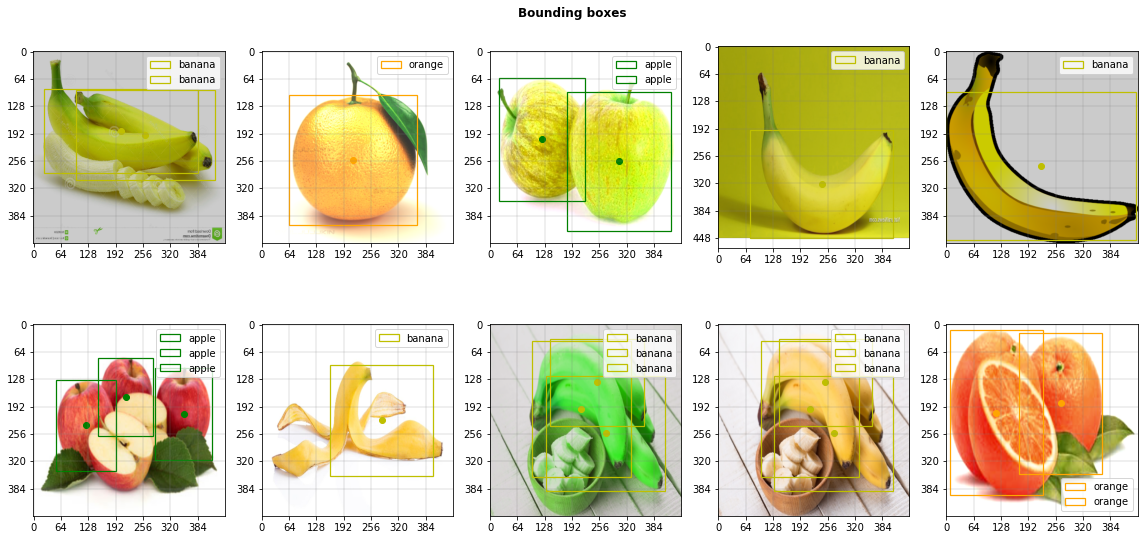

In [7]:
visualize_data(dataset=train_dataset)

In [8]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=4,
    shuffle=True)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4, 
    shuffle=False
    )

Теперь определим функцию для рассчета Intersection Over Union по 4 углам двух прямоугольников

In [9]:
def intersection_over_union(predicted_bbox, gt_bbox, is_list:bool=False) -> float:
    """
    Intersection Over Union для двух прямоугольников

    :param: predicted_bbox - [x_cell, y_cell, width_cell, height_cell]
    :param: gt_bbox - [x_cell, y_cell, width_cell, height_cell]
    
    :return: Intersection Over Union
    """
    if is_list:
        pred_box_x_min = predicted_bbox[0] - predicted_bbox[2] / 2
        pred_box_y_min = predicted_bbox[1] - predicted_bbox[3] / 2
        pred_box_x_max = predicted_bbox[0] + predicted_bbox[2] / 2
        pred_box_y_max = predicted_bbox[1] + predicted_bbox[3] / 2
        true_box_x_min = gt_bbox[0] - gt_bbox[2] / 2
        true_box_y_min = gt_bbox[1] - gt_bbox[3] / 2
        true_box_x_max = gt_bbox[0] + gt_bbox[2] / 2
        true_box_y_max = gt_bbox[1] + gt_bbox[3] / 2

        x1 = max(pred_box_x_min, true_box_x_min, 0)
        y1 = max(pred_box_y_min, true_box_y_min, 0)
        x2 = min(pred_box_x_max, true_box_x_max, 0)
        y2 = min(pred_box_y_max, true_box_y_max, 0)

        intersection_area = (x2 - x1) * (y2 - y1)
    else:
        pred_box_x_min = predicted_bbox[..., 0:1] - predicted_bbox[..., 2:3] / 2
        pred_box_y_min = predicted_bbox[..., 1:2] - predicted_bbox[..., 3:4] / 2
        pred_box_x_max = predicted_bbox[..., 0:1] + predicted_bbox[..., 2:3] / 2
        pred_box_y_max = predicted_bbox[..., 1:2] + predicted_bbox[..., 3:4] / 2
        true_box_x_min = gt_bbox[..., 0:1] - gt_bbox[..., 2:3] / 2
        true_box_y_min = gt_bbox[..., 1:2] - gt_bbox[..., 3:4] / 2
        true_box_x_max = gt_bbox[..., 0:1] + gt_bbox[..., 2:3] / 2
        true_box_y_max = gt_bbox[..., 1:2] + gt_bbox[..., 3:4] / 2


        x1 = torch.max(pred_box_x_min, true_box_x_min)
        y1 = torch.max(pred_box_y_min, true_box_y_min)
        x2 = torch.min(pred_box_x_max, true_box_x_max)
        y2 = torch.min(pred_box_y_max, true_box_y_max)

        intersection_area = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    pred_box_area = abs((pred_box_x_max - pred_box_x_min) * (pred_box_y_max - pred_box_y_min))
    true_box_area = abs((true_box_x_max - true_box_x_min) * (true_box_y_max - true_box_y_min))
    union_area = pred_box_area + true_box_area - intersection_area

    iou = intersection_area / union_area + 1e-10
    return iou

Теперь начинается основная часть домашнего задания: обучите модель YOLO для object detection на __обучающем__ датасете. 

 - Создайте модель и функцию ошибки YoloV1 прочитав [оригинальную статью](https://paperswithcode.com/paper/you-only-look-once-unified-real-time-object)
 - Напишите функцию обучения модели
 - Используйте аугментации

## Реализуйте Модель - 2 балла

Копировать точное количество слоев и параметры сверток необязательно. Главное - чтобы модель работала по принципу, описанному в статье и делала предсказание в представленном формате.


В качестве подсказки напомним, что выходом модели __для каждого обьекта__ должен быть тензор размера
__S * S * (B * 5 + С)__, где все параметры имеют такое же значение, как и в статье: 

- S - количество ячеек на которое разбивается изображение по вертикали/горизонтали
- В - количество предсказываемых прямоугольников в каждой ячейке
- 5 - количество параметров для определения каждого прямоугольника (x_center, y_center, width, height, confidence)
- С - количество классов (apple, banana, orange)

Таким образом, мы для каждого окна размера __S x S__ предсказываем __В__ коробо и один класс

In [10]:
class CNNBlock(nn.Module):  # можно поменять на Lightning
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels, 
                              kernel_size=kernel_size,
                              stride=stride, padding=padding)
        self.batchnorm = nn.BatchNorm2d(out_channels)  # в статье еще не знали про батчнорм, но мы то из будущего ...
        self.leakyrelu = nn.LeakyReLU(0.1)

        
    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        x = self.leakyrelu(x)

        return x
    
class YOLO(nn.Module):
    def __init__(self, S=7, B=2, C=3, in_channels=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super(YOLO, self).__init__()

        self.S = S
        self.B = B
        self.C = C

        self.darknet = nn.Sequential(
            CNNBlock(in_channels=3, out_channels=64,
                     kernel_size=7, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            CNNBlock(in_channels=64, out_channels=128,
                     kernel_size=3),
            CNNBlock(in_channels=128, out_channels=192,
                     kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            CNNBlock(in_channels=192, out_channels=256,
                     kernel_size=3),
            CNNBlock(in_channels=256, out_channels=512,
                     kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            CNNBlock(in_channels=512, out_channels=512,
                     kernel_size=3),
            CNNBlock(in_channels=512, out_channels=1024,
                     kernel_size=3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            CNNBlock(in_channels=1024, out_channels=1024,
                     kernel_size=3, stride=2),
            CNNBlock(in_channels=1024, out_channels=1024,
                     kernel_size=3),
            CNNBlock(in_channels=1024, out_channels=1024,
                     kernel_size=3),
        )

        self.connected_layers = nn.Sequential(
            nn.Linear(1024*self.S*self.S, 4096),
            nn.LeakyReLU(0.1),
            nn.Linear(4096, self.S * self.S * (self.B*5 + self.C))
        )

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(0)
        else:
            pass
        x = self.darknet(x)
        x = x.view(x.size()[0], -1)
        x = self.connected_layers(x)
        self.pred = x.reshape(-1, (self.B*5 + self.C), self.S, self.S)
        return self.pred

temp_model = YOLO()
expected_output_shape = temp_model.S * temp_model.S * (5 * temp_model.B + temp_model.C)

assert temp_model(train_dataset[0][0]).reshape(-1).shape[0] == train_dataset[0][1].reshape(-1).shape[0]
assert temp_model(train_dataset[0][0]).reshape(-1).shape[0] == expected_output_shape

## Реализуйте YoloLoss - 3 балла

In [11]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super().__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5
        self.epsilon = 1e-20

    def forward(self, predictions, target):
        predictions = predictions.reshape(target.shape)
        batch_size = target.shape[0]
        first_part_of_loss = 0.0
        second_part_of_loss = 0.0
        third_part_of_loss = 0.0
        fourth_part_of_loss = 0.0
        fifth_part_of_loss = 0.0

        for batch in range(batch_size):
            for i in range(self.S):
                for k in range(self.S):
                    if target[batch, i, k, self.C+5-1] == 1:
                        true_bbox = target[batch, i, k, self.C:self.C+4]
                        ious = []
                        # print(true_bbox)
                        for j in range(self.B):
                            pred_bbox = predictions[batch, i, k, self.C+5*j:self.C+4+5*j]
                            iou = intersection_over_union(true_bbox,pred_bbox)
                            ious.append(iou)

                        if ious[0] > ious[1]:
                            pointer = 0
                            obj_confidence = ious[0]
                        else:
                            obj_confidence = ious[1]
                            pointer = 5
                        noobj_confidence = 0

                        # first part of YOLO loss (xs and ys)
                        xs = target[batch, i, k, self.C+pointer:self.C+pointer+1]
                        xs_hat = predictions[batch, i, k, self.C+pointer:self.C+pointer+1]

                        ys = target[batch, i, k, self.C+pointer+1]
                        ys_hat = predictions[batch, i, k, self.C+pointer+1]
                        # print(ys.shape, ys_hat.shape)
                        first_part_of_loss += self.mse(xs, xs_hat) + self.mse(xs, xs_hat)
                        
                        # second part of YOLO loss (ws and hs)
                        sqrt_ws = torch.sqrt(abs(target[batch, i, k, self.C+pointer+2:self.C+pointer+3]))
                        sqrt_ws_hat = torch.sqrt(abs(predictions[batch, i, k, self.C+pointer+2:self.C+pointer+3]))
                        # print(sqrt_ws.shape, sqrt_ws_hat.shape)

                        sqrt_hs = torch.sqrt(abs(target[batch, i, k, self.C+pointer+3:self.C+pointer+4]))
                        sqrt_hs_hat = torch.sqrt(abs(predictions[batch, i, k, self.C+pointer+3:self.C+pointer+4]))
                        # print(sqrt_hs.shape, sqrt_hs_hat.shape)

                        second_part_of_loss += self.mse(sqrt_ws, sqrt_ws_hat) + \
                                              self.mse(sqrt_hs, sqrt_hs_hat)

                        # third part of YOLO loss (obj C)
                        obj_confidence_hat = predictions[batch, i, k, self.C+5+pointer-1:self.C+5+pointer]
                        third_part_of_loss += self.mse(obj_confidence, obj_confidence_hat)

                        # fourth part of YOLO loss (noobj C)
                        noobj_confidence_hat = predictions[batch, i, k, self.C+5+abs(5-pointer)-1:self.C+5+abs(5-pointer)]
                        fourth_part_of_loss += torch.sum((noobj_confidence - noobj_confidence_hat) ** 2)

                        # fifth part of YOLO loss (classes)
                        pic = target[batch, i, k, :self.C]
                        pic_hat = predictions[batch, i, k, :self.C]
                        fifth_part_of_loss += self.mse(pic, pic_hat)
                    else:
                        noobj_confidence = 0
                        fourth_part_of_loss += torch.sum((noobj_confidence - predictions[batch, i, k, [self.C+5-1, self.C+5+5-1]]) ** 2)

        total_loss = (self.lambda_coord*first_part_of_loss + 
                      self.lambda_coord*second_part_of_loss +
                      third_part_of_loss +
                      self.lambda_noobj*fourth_part_of_loss +
                      fifth_part_of_loss)
        return total_loss / batch_size

## Реализуйте дополнительные функции из статьи - 2 балла

In [12]:
def bbox_converter(tensor:torch.tensor, S=7, C=3, B=2, is_pred:bool=False):
    result = []
    batch_size = tensor.shape[0]
    tensor = tensor.reshape(batch_size, S, S, 5*B + C)

    # get all bboxes (x_cell, y_cell, w_cell, h_cell)
    bboxes = [tensor[..., C+5*b:C+(b+1)*5-1] for b in range(B)]
    # get all confidence (for target c=1)
    confidences = torch.cat(([tensor[..., C+b*5-1].unsqueeze(0) for b in range(B)]), 
                            dim=0)
    
    # most confident bbox (for target - first bbox)
    high_confident = confidences.argmax(0).unsqueeze(-1)
    best_boxes = bboxes[0] * (1 - high_confident) + high_confident * bboxes[1]

    # ratio to image
    cell_indices = torch.arange(S).repeat(batch_size, S, 1).unsqueeze(-1).to(device)
    xs = 1/S * (best_boxes[..., :1] + cell_indices)
    ys = 1/S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    ws_hs = 1/S *(best_boxes[..., 2:4])
    # print(best_boxes[..., 2:3])

    converted_coordinates = torch.cat((xs, ys, ws_hs), dim=-1)
    predicted_class = tensor[..., :C].argmax(-1).unsqueeze(-1) # from 0,1,0 -> 1
    best_confidence = torch.max(tensor[..., C+4], 
                                tensor[..., C+4+5]).unsqueeze(-1)

    result = torch.cat((predicted_class, best_confidence,
                                  converted_coordinates), dim=-1)

    return result

def cellbox_to_bbox(tensor:torch.tensor, S=7):
    batch_size = tensor.shape[0]
    converted_pred = bbox_converter(tensor).reshape(batch_size, S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(tensor.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def non_max_suppression(bboxes, iou_threshold, threshold):
    sorted_bboxes = sorted(bboxes, reverse=True, key=lambda x: x[1])
    accepted_bboxes = [bbox for bbox in sorted_bboxes if bbox[1] > threshold]
    result_bboxes = []

    while len(accepted_bboxes) > 0:
        current_bbox = accepted_bboxes.pop(0)

        for bbox in accepted_bboxes:
            if current_bbox[0] != bbox[0]:
                iou = intersection_over_union(torch.tensor(current_bbox[2:]),
                                              torch.tensor(bbox[2:]))
                if iou > iou_threshold:
                    accepted_bboxes.remove(bbox)

        result_bboxes.append(current_bbox)

    return result_bboxes

def get_bound_boxes(loader, model, iou_threshold=.5, threshold=.4):
    all_pred_bboxes = []
    all_true_bboxes = []
    
    model.eval()
    index = 0
    durations = []
    for iteration, batch in enumerate(loader):
        start = time.time()
        image, label_matrix = batch
        image, label_matrix = image.to(device), label_matrix.to(device)
        batch_size = image.shape[0]
        
        with torch.no_grad():
            pred = model(image)
        
        # print(label_matrix[..., C:])
        true_bboxes = cellbox_to_bbox(label_matrix)
        pred_bboxes = cellbox_to_bbox(pred)

        for batch_idx in range(batch_size):
            non_maximum_supression_bboxes = non_max_suppression(
                pred_bboxes[batch_idx], iou_threshold=iou_threshold,
                threshold=threshold
            )

            for nms_bbox in non_maximum_supression_bboxes:
                all_pred_bboxes.append([index] + nms_bbox)

            for bbox in true_bboxes[batch_idx]:
                # check confidence
                if bbox[1] > threshold:
                    all_true_bboxes.append([index] + bbox)

        index += 1

        end = time.time()
        elapsed_time = end - start

        durations.append(elapsed_time)
    model.train()

    return all_pred_bboxes, all_true_bboxes

Let's RECALL some formulas.
<br>
$$ Precision = {TP \over TP + FP} $$
<br>
$$ Recall = {TP \over TP + FN} $$
<br>
$$ TP + FN = Number \space Of \space Positive \space Observations $$



In [13]:
from collections import Counter
def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, S=7, C=3, B=2):
    mAP = []
    epsilon = 1e-10
    # iter through classes
    for c in range(C):
        # we take 1st index, because of the batch index at 0 position
        pred_labels = [bbox for bbox in pred_boxes if bbox[1] == c] 
        true_labels = [bbox for bbox in true_boxes if bbox[1] == c]
        # print(pred_labels)

        # let's define covered bboxes [0] - if not covered, else [1]
        # this is essential for FP situatuion
        all_loader_indices = [bbox[0] for bbox in true_labels]
        loader_indices = set(all_loader_indices)
        n_loader_index = [torch.zeros(all_loader_indices.count(loader_index)) for loader_index in loader_indices]

        covered_bboxes = dict(zip(loader_indices, n_loader_index))
        # print(covered_bboxes[0][0])

        n_true_labels = len(true_labels)
        TP = torch.zeros(len(pred_labels))
        FP = torch.zeros(len(pred_labels))

        # iter through predictions
        for prediction_index, prediction in enumerate(pred_labels):
            loader_index = prediction[0]

            # now we should take only these truths, which are in the same batch
            # as our predictions
            related_truths = [bbox for bbox in true_labels if bbox[0] == prediction[0]]
            n_batch_truth = len(related_truths)

            # now iterate through batch_truths
            best_iou = 0
            for index_of_related_truth, related_truth in enumerate(related_truths):
                  iou = intersection_over_union(
                      prediction[3:], 
                      related_truth[3:], is_list=True
                  )
                  if iou > best_iou:
                      best_iou = iou
                      best_match_index = index_of_related_truth
            # print(best_iou)
            # now, when we've taken one bbox for a class (class=c),
            # we can can compare that bbox between all target bbox

            # if pred is correct? (according to threshold)
            if best_iou > iou_threshold:
                # do we covered this particular bbox?
                # print(covered_bboxes[loader_index][best_match_index])
                if covered_bboxes[loader_index][best_match_index] == 0.0:
                    # IOU > threshold, class is correct -> TP
                    TP[prediction_index] = 1
                    # now we cover bbox
                    covered_bboxes[loader_index][best_match_index] = 1
                else:
                    # bbox is duplicated -> FP
                    FP[prediction_index] = 1
            else:
                # IOU <= threshold, class is correct -> FP
                FP[prediction_index] = 1
        
        # print(covered_bboxes)
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (n_true_labels + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        
        # now we should calculate area under PR-curve
        mAP.append(torch.trapz(precisions, recalls))
    
    return sum(mAP) / len(mAP)

## Обучите модель и посчитайте метрики для задачи детекции - 2 балла 

Несмотря на то, что в этом блоке ничего сильно нового для вас не ожидается и за него формально дается лишь два балла - провести обучение очень важно для понимания того, насколько правильно реализована ваша модель и лосс.

В процессе обучения будет видно все ли размерности совпадают, падает ли лосс и растут ли метрики целевой задачи, поэтому на практике этот пункт гораздо оказывается гораздо важнее.

In [14]:
def YOLOtrain(model, train_dataloader:DataLoader, 
              loss_function, optimizer):
    model.train()
    train_loss = 0.0

    for data in tqdm(train_dataloader):
        optimizer.zero_grad()

        image, label_matrix = data
        image, label_matrix = image.to(device), label_matrix.to(device)
        predictions = model(image)
        loss = loss_function(predictions, label_matrix)

        train_loss += loss.data.item()

        loss.backward()
        optimizer.step()
    wandb.log({"train loss": train_loss})
    return train_loss

In [15]:
def YOLOeval(model, test_dataloader:DataLoader, 
              loss_function):
    model.eval()
    test_loss = 0.0

    prediction_bboxes, true_bboxes = get_bound_boxes(test_dataloader, model)

    mAP = mean_average_precision(pred_boxes=prediction_bboxes, true_boxes=true_bboxes)
    with torch.no_grad():
        for data in tqdm(test_dataloader):

            image, label_matrix = data
            image, label_matrix = image.to(device), label_matrix.to(device)
            predictions = model(image)
            loss = loss_function(predictions, label_matrix)

            test_loss += loss.data.item()
    wandb.log({"test loss": test_loss})
    return test_loss, mAP

In [16]:
wandb.init(entity="nikitaermishov", project="YOLOV1")
wandb.watch_called = False 

config = wandb.config         
config.batch_size = 4          
config.test_batch_size = 4   
config.epochs = 50             
config.lr = 1e-5                     
config.no_cuda = False         
config.seed = 2002               
config.log_interval = 10

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nikitaermishov. Use `wandb login --relogin` to force relogin


In [17]:
model = YOLO().to(device)

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr,
                             weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
    factor=0.1, patience=10, threshold=1e-4, threshold_mode='abs')
loss_fn = YoloLoss()

In [19]:
wandb.watch(model, log="all")

for epoch in range(config.epochs):
    if epoch in range(9):
        print(f'epoch №0{epoch+1} is currently running...')
    else:
        print(f'epoch №{epoch+1} is currently running...')

    train_loss = YOLOtrain(model=model, train_dataloader=train_dataloader,
              optimizer=optimizer, loss_function=loss_fn)
    val_loss, val_mAP = YOLOeval(model=model, test_dataloader=val_dataloader, 
                        loss_function=loss_fn)
    scheduler.step(val_loss)
    print(f'train loss: {train_loss} \ntest loss: {val_loss}, test mAP: {val_mAP}')

epoch №01 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 725.0835192203522 
test loss: 119.76652479171753, test mAP: 0.01730172149837017
epoch №02 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 517.0132284164429 
test loss: 98.09538912773132, test mAP: 0.026147576048970222
epoch №03 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 533.1365857124329 
test loss: 160.85682773590088, test mAP: 0.0
epoch №04 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 468.4702138900757 
test loss: 111.79460370540619, test mAP: 0.0
epoch №05 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 424.3874921798706 
test loss: 95.35226726531982, test mAP: 0.0
epoch №06 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 352.2603049278259 
test loss: 83.64882302284241, test mAP: 0.0
epoch №07 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 293.7253682613373 
test loss: 85.81908321380615, test mAP: 0.0
epoch №08 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 268.5053485631943 
test loss: 76.19301199913025, test mAP: 0.0
epoch №09 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 250.11538934707642 
test loss: 72.87671160697937, test mAP: 0.0
epoch №10 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 252.37207239866257 
test loss: 66.9414633512497, test mAP: 0.0
epoch №11 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 257.48010635375977 
test loss: 93.76268339157104, test mAP: 0.0
epoch №12 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 260.5940902233124 
test loss: 71.37185978889465, test mAP: 0.0
epoch №13 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 251.1191849708557 
test loss: 72.59544932842255, test mAP: 0.0
epoch №14 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 234.68339174985886 
test loss: 70.65288233757019, test mAP: 0.0
epoch №15 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 221.9877940416336 
test loss: 79.55661642551422, test mAP: 0.0
epoch №16 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 229.7136126756668 
test loss: 71.28400731086731, test mAP: 0.0
epoch №17 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 241.68781220912933 
test loss: 66.42826187610626, test mAP: 0.0
epoch №18 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 224.43821996450424 
test loss: 72.46085810661316, test mAP: 0.0
epoch №19 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 246.52079939842224 
test loss: 78.99815607070923, test mAP: 0.0
epoch №20 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 258.89454078674316 
test loss: 69.16252648830414, test mAP: 0.0
epoch №21 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 253.85365319252014 
test loss: 94.010622382164, test mAP: 0.0
epoch №22 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 256.0818955898285 
test loss: 73.3898434638977, test mAP: 0.0
epoch №23 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 242.81818056106567 
test loss: 64.78719770908356, test mAP: 0.0
epoch №24 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 244.95407915115356 
test loss: 72.87396204471588, test mAP: 0.0
epoch №25 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 236.19974601268768 
test loss: 64.57563877105713, test mAP: 0.0
epoch №26 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 229.86048531532288 
test loss: 63.83321750164032, test mAP: 0.0
epoch №27 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 221.3075528740883 
test loss: 56.75044071674347, test mAP: 0.0
epoch №28 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 218.8254964351654 
test loss: 70.35193645954132, test mAP: 0.0
epoch №29 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 228.04605269432068 
test loss: 75.29607951641083, test mAP: 0.0
epoch №30 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 242.90992724895477 
test loss: 64.45729911327362, test mAP: 0.0
epoch №31 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 221.06925457715988 
test loss: 65.85255467891693, test mAP: 0.0
epoch №32 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 229.66525369882584 
test loss: 61.14361774921417, test mAP: 0.0
epoch №33 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 235.98234903812408 
test loss: 63.58688688278198, test mAP: 0.0
epoch №34 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 216.87414902448654 
test loss: 62.473671197891235, test mAP: 0.0
epoch №35 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 217.0436059832573 
test loss: 59.50845015048981, test mAP: 0.0
epoch №36 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 210.77911388874054 
test loss: 64.38732838630676, test mAP: 0.0
epoch №37 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 214.6008780002594 
test loss: 65.32838177680969, test mAP: 0.0
epoch №38 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 225.4330825805664 
test loss: 60.24803578853607, test mAP: 0.0
epoch №39 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 186.98554825782776 
test loss: 51.38364100456238, test mAP: 0.0
epoch №40 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 152.58817201852798 
test loss: 47.63281774520874, test mAP: 0.0
epoch №41 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 137.41432774066925 
test loss: 46.18763732910156, test mAP: 0.0
epoch №42 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 127.28443855047226 
test loss: 43.61546856164932, test mAP: 0.0
epoch №43 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 127.30532491207123 
test loss: 43.256202936172485, test mAP: 0.0
epoch №44 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 118.14045095443726 
test loss: 41.69017553329468, test mAP: 0.0
epoch №45 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 120.69513887166977 
test loss: 41.34137827157974, test mAP: 0.0
epoch №46 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 116.0903999209404 
test loss: 40.41510623693466, test mAP: 0.0
epoch №47 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 107.56882873177528 
test loss: 41.21147608757019, test mAP: 0.0
epoch №48 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 102.27818471193314 
test loss: 41.62144231796265, test mAP: 0.0
epoch №49 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 106.67389929294586 
test loss: 39.69982445240021, test mAP: 0.0
epoch №50 is currently running...


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss: 98.13059523701668 
test loss: 39.40212744474411, test mAP: 0.0


In [20]:
def empty_device_memory():
    torch.cuda.empty_cache()
    gc.collect()

## Посчитайте метрики задачи детекции на валидационной выборке

Попробуйте понять насколько хороши ваши показатели. Если числа кажутся подозрительно низкими - возможно вам стоит перепроверить ваше решение. 

In [21]:
YOLOeval(model, val_dataloader, loss_fn)

  0%|          | 0/15 [00:00<?, ?it/s]

(39.40212744474411, tensor(0.))

## Визуализируйте предсказанные bounding box'ы для любых пяти картинок из __валидационного__ датасета.

In [46]:
def visualize_preds(dataset, model, idx=0, samples=10, cols=5, random=True, S=7):
    dataset = copy.deepcopy(dataset)
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=((16, 8)))
    for i in range(samples):
        if random:
            idx = np.random.randint(1,len(dataset))
        image, target_tensor = dataset[idx]
        preds = model(image.to(device))[0]
        image = image.detach().numpy()
        image = image.swapaxes(0,1)
        image = image.swapaxes(1,2)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_size, _, _ = image.shape
        cell_size = image_size/S
        x_centres = []
        y_centres = []
        ax.ravel()[i].imshow(image)
        for k in range(S):
            if torch.sum(target_tensor[k]) > 0:
                for j in range(S):
                    if torch.sum(target_tensor[k][j]) > 0:
                        x_center, y_center, width, height =  target_tensor[k][j][C:C-1+5]
                        x_center_initial = (x_center + k)*cell_size
                        y_center_initial = (y_center + j)*cell_size
                        
                        width, height = width/S, height/S
                        x_min = x_center_initial - width*image_size / 2
                        y_min = y_center_initial - height*image_size / 2
                        label =(target_tensor[k][j][:C]).argmax(0) + 1
                        class_, color = get_class_and_color(label)
                        rect = patches.Rectangle((x_min, y_min),
                                                  width * image_size,
                                                  height * image_size,
                                                  linewidth=1.25,
                                                  edgecolor=color,
                                                  facecolor="none",
                                                  label=class_)
                        ax.ravel()[i].scatter(x_center_initial, y_center_initial, c=color)
                        ax.ravel()[i].add_patch(rect)

                        x_center, y_center, width, height =  preds[k][j][C:C-1+5].to('cpu').detach().numpy()
                        x_center_initial = (x_center + k)*cell_size
                        y_center_initial = (y_center + j)*cell_size
                        
                        width, height = width/S, height/S
                        x_min = x_center_initial - width*image_size / 2
                        y_min = y_center_initial - height*image_size / 2
                        label = (preds[k][j][:C]).argmax(0) + 1
                        class_, color = get_class_and_color(label)
                        rect = patches.Rectangle((x_min, y_min),
                                                  width * image_size,
                                                  height * image_size,
                                                  linewidth=1.25,
                                                  edgecolor='black',
                                                  facecolor="none",
                                                  label=class_+'_pred')
                        ax.ravel()[i].scatter(x_center_initial, y_center_initial, c='black')
                        ax.ravel()[i].add_patch(rect)
        loc = plt.matplotlib.ticker.MultipleLocator(base=image_size/dataset.S)
        ax.ravel()[i].xaxis.set_major_locator(loc)
        ax.ravel()[i].yaxis.set_major_locator(loc)
        ax.ravel()[i].grid(which='major', axis='both', linestyle='-', linewidth=0.25, color='grey')
        ax.ravel()[i].legend(loc='upper right')
    plt.suptitle('Bounding boxes', fontweight='bold')
    plt.tight_layout()
    plt.legend()
    plt.show()

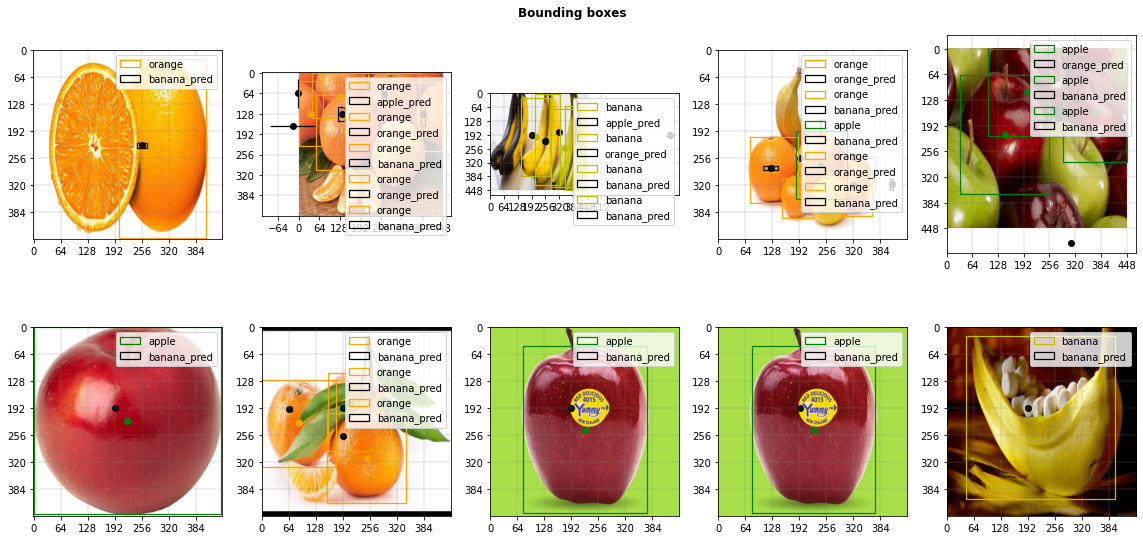

In [47]:
visualize_preds(val_dataset, model)

* Вроде бы все сделал, но mAP уходит в ноль, даже по гайду если пилить... (ссылка на гайд: https://www.youtube.com/watch?v=FppOzcDvaDI&ab_channel=AladdinPersson)
* Ссылка на wandb: https://wandb.ai/nikitaermishov/YOLOV1?workspace=user-nikitaermishov

